# **Delta Hedging with SPX Options**

This simulation models the pricing and delta sensitivity of an at-the-money (ATM) SPX call option over time and demonstrates the effectiveness of delta hedging in managing option risk. In this approach, we will long an SPX option at a delta of 0.5 (At-The-Money) and a one-month maturity. Implied volatility will be used to perform dynamic delta hedging throughout the option's life, with adjustments made continuously until the option expires.

*We will use the VIX to represent implied volatility and constant annualized risk-free rate using the historical 1-year Treasury rate. Assume liquid and frictionless markets.

In [57]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew, kurtosis

# Download VIX data
vix_data = yf.download('^VIX', start="2006-03-01", end="2024-12-20")
print(vix_data.head())

# Download SPX data
spx_ticker = "^GSPC"
spx_data = yf.download(spx_ticker, start="2006-03-01", end="2024-12-20", interval="1d")

[*********************100%***********************]  1 of 1 completed


Price      Adj Close  Close   High    Low   Open Volume
Ticker          ^VIX   ^VIX   ^VIX   ^VIX   ^VIX   ^VIX
Date                                                   
2006-03-01     11.54  11.54  12.07  11.52  12.05      0
2006-03-02     11.72  11.72  11.95  11.56  11.79      0
2006-03-03     11.96  11.96  12.10  11.36  12.03      0
2006-03-06     12.74  12.74  12.91  12.22  12.22      0
2006-03-07     12.66  12.66  13.34  12.64  12.92      0


[*********************100%***********************]  1 of 1 completed


In [62]:
from google.colab import files
uploaded = files.upload()

file_names = list(uploaded.keys())

expiration_data = pd.read_csv(file_names[0])
expiration_data['Expiration'] = pd.to_datetime(expiration_data['Expiration'], format='%m/%d/%y')

rf_rate_data = pd.read_csv(file_names[1])

Saving expiration.csv to expiration (8).csv
Saving yearly_rates.csv to yearly_rates (8).csv


Now that we have our data, we need to reformat it so that we can use it efficiently. vix_data and spx_data have multilevel indexes. By taking the second level values and retaining only the "Close" column, we create new dataframes that only include the date and closing price of VIX and SPX. We  reset the index to make 'Date' a regular column and then merge the datasets by date.

In [58]:
# For VIX data
vix_data.columns = vix_data.columns.get_level_values(1)  # Flatten the multi-level columns
vix_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
vix_vol = vix_data[['Close']].copy()  # Extract Close column
vix_vol.index = pd.to_datetime(vix_vol.index).normalize().tz_localize(None)  # Normalize and remove timezone
vix_vol.reset_index(inplace=True)  # Reset the index and add it as a column
vix_vol.rename(columns={'index': 'Date'}, inplace=True)  # Rename 'index' column to 'Date'

# For SPX data
spx_data.columns = spx_data.columns.get_level_values(1)
spx_data.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
spx_data = spx_data[['Close']].copy()  # Extract Close column
spx_data.index = pd.to_datetime(spx_data.index).normalize().tz_localize(None)
spx_data.reset_index(inplace=True)
spx_data.rename(columns={'index': 'Date'}, inplace=True)

backtest_data = pd.merge(spx_data[['Date', 'Close']], vix_vol[['Date', 'Close']], on='Date', suffixes=('_spx', '_vix'))

Then merging our vix and spx data with contract expiration dates.

In [63]:
combined_data = pd.merge_asof(
    backtest_data,
    expiration_data,
    left_on='Date',
    right_on='Expiration',
    direction='forward'
)

Then to assign our rates to the data, we merge by year.

In [65]:
# Ensure the 'Year' column in both DataFrames has the same type
combined_data['Year'] = pd.to_datetime(combined_data['Date']).dt.year  # Extract year from datetime
rf_rate_data['Year'] = pd.to_datetime(rf_rate_data['Year']).dt.year

combined_data = combined_data.merge(rf_rate_data, on='Year', how='left')
# Check the merged result
print(combined_data.head())


        Date    Close_spx  Close_vix Expiration  Year  Rate
0 2006-03-01  1280.660034      11.52 2006-03-24  2006  4.94
1 2006-03-02  1283.209961      11.56 2006-03-24  2006  4.94
2 2006-03-03  1284.199951      11.36 2006-03-24  2006  4.94
3 2006-03-06  1275.670044      12.22 2006-03-24  2006  4.94
4 2006-03-07  1271.109985      12.64 2006-03-24  2006  4.94


<ipython-input-65-bf389fa2a5dd>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  rf_rate_data['Year'] = pd.to_datetime(rf_rate_data['Year']).dt.year


In [67]:
print(str(combined_data))

           Date    Close_spx  Close_vix Expiration  Year  Rate
0    2006-03-01  1280.660034      11.52 2006-03-24  2006  4.94
1    2006-03-02  1283.209961      11.56 2006-03-24  2006  4.94
2    2006-03-03  1284.199951      11.36 2006-03-24  2006  4.94
3    2006-03-06  1275.670044      12.22 2006-03-24  2006  4.94
4    2006-03-07  1271.109985      12.64 2006-03-24  2006  4.94
...         ...          ...        ...        ...   ...   ...
4721 2024-12-02  6035.330078      13.30 2024-12-20  2024  4.72
4722 2024-12-03  6033.390137      13.19 2024-12-20  2024  4.72
4723 2024-12-04  6061.060059      12.89 2024-12-20  2024  4.72
4724 2024-12-05  6072.899902      13.26 2024-12-20  2024  4.72
4725 2024-12-06  6079.979980      12.70 2024-12-20  2024  4.72

[4726 rows x 6 columns]


Using the Black-Scholes model, we calculate the theoretical price and delta of a one-month ATM SPX call option. We define the Black-Scholes formula function:

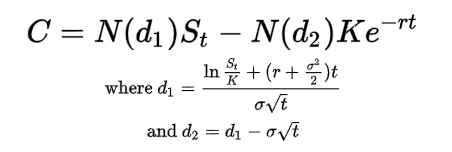

In [70]:
# Calculate Days to Maturity and T
combined_data['Days_to_Maturity'] = (combined_data['Expiration'] - combined_data['Date']).dt.days
combined_data['T'] = combined_data['Days_to_Maturity'] / 365

def black_scholes(S, K, T, r, sigma):
    sigma = max(sigma, 1e-6)  # Avoid zero or near-zero volatility
    T = max(T, 1e-6)  # Avoid zero or near-zero time to maturity
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # Calculate call option price and delta
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

combined_data['Strike_Price'] = combined_data['Close_spx']

combined_data[['Option_Price', 'Delta']] = combined_data.apply(
    lambda row: pd.Series(
        black_scholes(
            S=row['Close_spx'],                # Spot price
            K=row['Strike_Price'],             # Strike price
            T=row['T'],                        # Time to maturity in years
            r=row['Rate'] / 100,               # Annual risk-free rate (converted to decimal)
            sigma=row['Close_vix'] / 100       # Implied volatility (converted to decimal)
        )
    ),
    axis=1
)

In [71]:
print(str(combined_data))

           Date    Close_spx  Close_vix Expiration  Year  Rate  \
0    2006-03-01  1280.660034      11.52 2006-03-24  2006  4.94   
1    2006-03-02  1283.209961      11.56 2006-03-24  2006  4.94   
2    2006-03-03  1284.199951      11.36 2006-03-24  2006  4.94   
3    2006-03-06  1275.670044      12.22 2006-03-24  2006  4.94   
4    2006-03-07  1271.109985      12.64 2006-03-24  2006  4.94   
...         ...          ...        ...        ...   ...   ...   
4721 2024-12-02  6035.330078      13.30 2024-12-20  2024  4.72   
4722 2024-12-03  6033.390137      13.19 2024-12-20  2024  4.72   
4723 2024-12-04  6061.060059      12.89 2024-12-20  2024  4.72   
4724 2024-12-05  6072.899902      13.26 2024-12-20  2024  4.72   
4725 2024-12-06  6079.979980      12.70 2024-12-20  2024  4.72   

      Days_to_Maturity         T  Strike_Price  Option_Price     Delta  
0                   23  0.063014   1280.660034     16.826608  0.548592  
1                   22  0.060274   1283.209961     16.494061 

To maintain a delta-neutral portfolio, SPX stock is shorted in proportion to the option's delta. At the beginning of each month, the strike price is reset to the current SPX level, reflecting a strategy of initiating a new ATM option monthly. The simulation evaluates the effectiveness of delta hedging under two scenarios: daily rebalancing, where the hedge is dynamically adjusted daily to maintain delta neutrality, and monthly rebalancing, where adjustments are made only at the start of each month. By comparing these approaches, the simulation highlights the trade-offs between hedging accuracy, transaction costs, and portfolio performance, demonstrating how delta hedging can mitigate risk effectively under different rebalancing frequencies.

In [72]:
Q = 100  # Quantity of options
transaction_cost_rate = 0.0005  # Transaction cost (0.05% per transaction)

# Initialize columns if not already present
spx_complete = combined_data.copy()  # Use combined_data as the base DataFrame
spx_complete['Hedging_Position'] = 0.0
spx_complete['Transaction_Cost'] = 0.0
spx_complete['Cash_Position'] = 0.0
spx_complete['Interest_Accrued'] = 0.0
spx_complete['Portfolio_Value'] = 0.0
spx_complete['Option_Price'] = 0.0
spx_complete['Delta'] = 0.0

# Calculate initial option price and delta
initial_option_price, initial_delta = black_scholes(
    S=spx_complete.at[0, 'Close_spx'],          # Spot price
    K=spx_complete.at[0, 'Close_spx'],          # ATM strike price
    T=spx_complete.at[0, 'T'],                  # Time to maturity in years
    r=spx_complete.at[0, 'Rate'] / 100,         # Risk-free rate
    sigma=spx_complete.at[0, 'Close_vix'] / 100  # Implied volatility
)

spx_complete.at[0, 'Option_Price'] = initial_option_price
spx_complete.at[0, 'Delta'] = initial_delta
spx_complete.at[0, 'Hedging_Position'] = -initial_delta * Q
spx_complete.at[0, 'Transaction_Cost'] = abs(spx_complete.at[0, 'Hedging_Position']) * spx_complete.at[0, 'Close_spx'] * transaction_cost_rate
spx_complete.at[0, 'Cash_Position'] = -spx_complete.at[0, 'Hedging_Position'] * spx_complete.at[0, 'Close_spx'] - spx_complete.at[0, 'Transaction_Cost']
spx_complete.at[0, 'Portfolio_Value'] = spx_complete.at[0, 'Cash_Position']

# Delta hedging loop
for i in range(1, len(spx_complete)):
    current_row = spx_complete.iloc[i]
    previous_row = spx_complete.iloc[i - 1]

    # Accrue interest on the previous cash position
    accrued_interest = previous_row['Cash_Position'] * (previous_row['Rate'] / 100) / 365
    spx_complete.at[i, 'Interest_Accrued'] = accrued_interest

    # Recalculate option price and delta
    option_price, delta = black_scholes(
        S=current_row['Close_spx'],
        K=current_row['Close_spx'],              # ATM strike price
        T=current_row['T'],                      # Time to maturity in years
        r=current_row['Rate'] / 100,             # Risk-free rate
        sigma=current_row['Close_vix'] / 100     # Implied volatility
    )

    spx_complete.at[i, 'Option_Price'] = option_price
    spx_complete.at[i, 'Delta'] = delta

    # Adjust hedging position
    new_hedging_position = -delta * Q
    position_change = new_hedging_position - previous_row['Hedging_Position']
    transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

    spx_complete.at[i, 'Hedging_Position'] = new_hedging_position
    spx_complete.at[i, 'Transaction_Cost'] = transaction_cost

    # Update cash position
    cash_change = -position_change * current_row['Close_spx'] - transaction_cost
    new_cash_position = previous_row['Cash_Position'] + cash_change
    spx_complete.at[i, 'Cash_Position'] = new_cash_position + accrued_interest

    # Calculate portfolio value
    portfolio_value = option_price * Q + new_cash_position
    spx_complete.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate daily PnL
spx_complete['Daily_PnL'] = spx_complete['Portfolio_Value'].diff()

Then we rebalance monthly:

In [75]:
Q = 100
transaction_cost_rate

def is_month_start(current_date, previous_date):
    """Check if the current date is the start of a new month."""
    return current_date.month != previous_date.month

# Create a copy of the dataframe
spx_copy = combined_data.copy()

# Add new columns in the copied dataframe
spx_copy['Hedging_Position'] = 0.0
spx_copy['Transaction_Cost'] = 0.0
spx_copy['Cash_Position'] = 0.0
spx_copy['Portfolio_Value'] = 0.0
spx_copy['Interest_Accrued'] = 0.0

# Initial values (Day 0)
spx_copy.at[0, 'Hedging_Position'] = -spx_copy.at[0, 'Delta'] * Q
spx_copy.at[0, 'Transaction_Cost'] = abs(spx_copy.at[0, 'Hedging_Position']) * spx_copy.at[0, 'Close_spx'] * transaction_cost_rate
spx_copy.at[0, 'Cash_Position'] = -spx_copy.at[0, 'Hedging_Position'] * spx_copy.at[0, 'Close_spx'] - spx_copy.at[0, 'Transaction_Cost']
spx_copy.at[0, 'Portfolio_Value'] = spx_copy.at[0, 'Option_Price'] * Q + spx_copy.at[0, 'Cash_Position']

# Loop through each day to compute daily values
for i in range(1, len(spx_copy)):
    # Current and previous rows
    current_row = spx_copy.iloc[i]
    previous_row = spx_copy.iloc[i - 1]

    # Dynamically use the corresponding risk-free rate
    risk_free_rate = previous_row['Rate'] / 100  # Convert percentage to decimal

    # Accrue daily interest on the cash position
    interest_accrued = previous_row['Cash_Position'] * (risk_free_rate / 365)
    spx_copy.at[i, 'Interest_Accrued'] = interest_accrued

    # Check the start of a new month
    if is_month_start(current_row['Date'], previous_row['Date']):
        # Rebalance hedging position
        new_hedging_position = -current_row['Delta'] * Q
        position_change = new_hedging_position - previous_row['Hedging_Position']
        transaction_cost = transaction_cost_rate * abs(position_change) * current_row['Close_spx']

        spx_copy.at[i, 'Hedging_Position'] = new_hedging_position
        spx_copy.at[i, 'Transaction_Cost'] = transaction_cost

        # Update cash position due to rebalancing
        cash_change = -position_change * current_row['Close_spx'] - transaction_cost
        new_cash_position = previous_row['Cash_Position'] + cash_change
    else:
        # No rebalancing; carry forward hedging position and cash position
        spx_copy.at[i, 'Hedging_Position'] = previous_row['Hedging_Position']
        spx_copy.at[i, 'Transaction_Cost'] = 0.0
        new_cash_position = previous_row['Cash_Position']

    # Update cash position with interest accrued
    new_cash_position += interest_accrued
    spx_copy.at[i, 'Cash_Position'] = new_cash_position

    # Calculate portfolio value
    portfolio_value = current_row['Option_Price'] * Q + new_cash_position
    spx_copy.at[i, 'Portfolio_Value'] = portfolio_value

# Calculate daily PnL
spx_copy['Daily_PnL'] = spx_copy['Portfolio_Value'].diff()

We now plot our cumulative and monthly PnL to visualize our delta hedging strategy as well as the impact of rebalancing frequency.

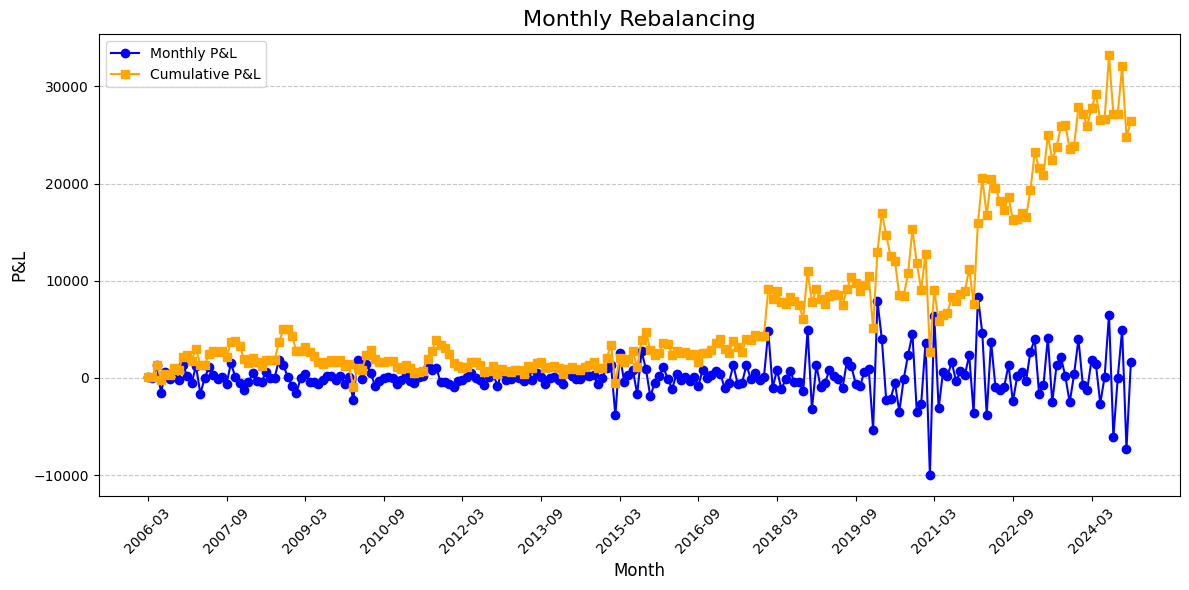

In [76]:
spx_copy['Month'] = spx_copy['Date'].dt.to_period('M')
monthly_pnl = spx_copy.groupby('Month')['Daily_PnL'].sum().reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

# Convert 'Month' to string for easier plotting
monthly_pnl['Month_Str'] = monthly_pnl['Month'].astype(str)

# Create the plot
plt.figure(figsize=(12, 6))

# Line plot for Monthly PnL
plt.plot(
    monthly_pnl['Month_Str'],
    monthly_pnl['Monthly_PnL'],
    marker='o',
    label='Monthly P&L',
    color='blue',
    linestyle='-'
)

# Line plot for Cumulative PnL
plt.plot(
    monthly_pnl['Month_Str'],
    monthly_pnl['Cumulative_PnL'],
    marker='s',
    label='Cumulative P&L',
    color='orange',
    linestyle='-'
)

# Add titles and labels
plt.title('Monthly Rebalancing', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('P&L', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

step = max(1, len(monthly_pnl['Month_Str']) // 12)
plt.xticks(ticks=range(0, len(monthly_pnl['Month_Str']), step), labels=monthly_pnl['Month_Str'][::step], rotation=45)

plt.tight_layout()
plt.show()

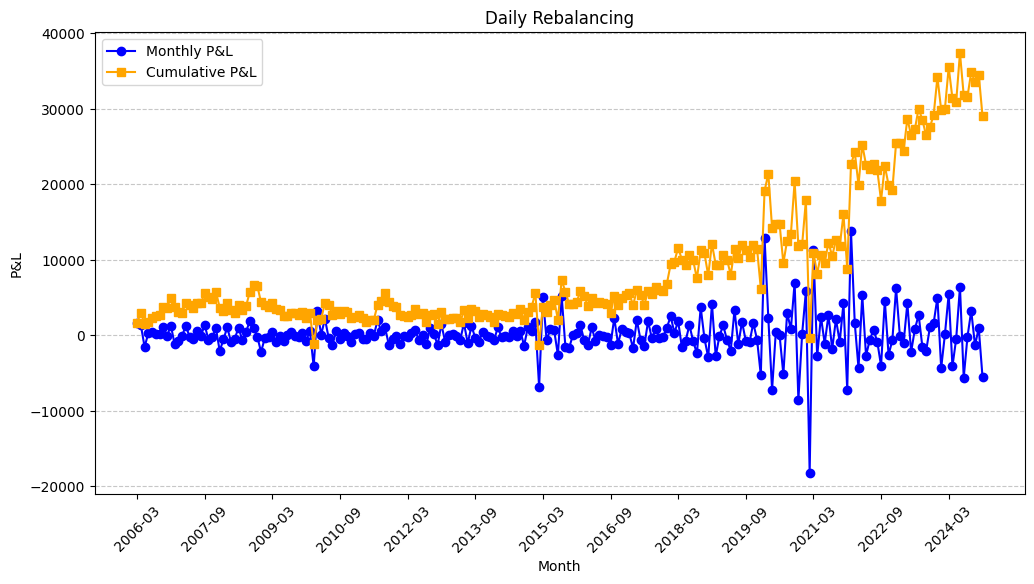

In [73]:
spx_complete['Month'] = spx_complete['Date'].dt.to_period('M')

# Calculate Monthly P&L
monthly_pnl = spx_complete.groupby('Month')['Daily_PnL'].sum().reset_index()
monthly_pnl.rename(columns={'Daily_PnL': 'Monthly_PnL'}, inplace=True)
spx_complete['Cumulative_PnL'] = spx_complete['Daily_PnL'].cumsum()
monthly_pnl['Cumulative_PnL'] = monthly_pnl['Monthly_PnL'].cumsum()

# Simplify x-axis
plt.figure(figsize=(12, 6))

# Convert 'Month' column to string
monthly_pnl['Month_Str'] = monthly_pnl['Month'].astype(str)

# Line plot for Monthly P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Monthly_PnL'], marker='o', label='Monthly P&L', color='blue')

# Line plot for Cumulative P&L
plt.plot(monthly_pnl['Month_Str'], monthly_pnl['Cumulative_PnL'], marker='s', label='Cumulative P&L', color='orange')

# Formatting
plt.title('Daily Rebalancing')
plt.xlabel('Month')
plt.ylabel('P&L')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Simplify x-axis ticks
step = len(monthly_pnl['Month_Str']) // 12  # Show only 12 ticks
plt.xticks(ticks=monthly_pnl['Month_Str'][::step], rotation=45)

# Show plot
plt.show()

**Monthly Rebalancing**

PnL exhibits smaller fluctuations compared to daily rebalancing. The blue line shows relatively consistent movement around zero, with no extreme outliers.
The cumulative PnL (orange line) grows steadily over time, with fewer drastic drops. This indicates that monthly rebalancing leads to smoother PnL growth.
Monthly rebalancing appears less sensitive to market volatility since adjustments happen less frequently, reducing transaction costs and the impact of minor market changes.


**Daily Rebalancing**
The daily PnL (blue line) is much more volatile, with significant spikes and dips. This reflects the frequent adjustments made to the hedging position, which amplifies the effect of daily market fluctuations. The cumulative PnL (orange line) grows faster in certain periods (e.g., post-2020), but is also more sensitive to market disruptions. There are more pronounced drops compared to monthly rebalancing. Frequent rebalancing incurs higher transaction costs, which likely dampens the cumulative PnL growth.

---
# Conclusion

*   Monthly rebalancing allows for smoother and more stable cumulative PnL growth.
Lower transaction costs are incurred due to fewer trades and there is less sensitivity to short-term market volatility.
*   Daily rebalancing has a higher sensitivity to market fluctuations leading to a
greater volatility in daily PnL. There is a potentially higher cumulative PnL in volatile markets but at the cost of increased transaction fees and risk.

The choice between these two strategies depends on the investor's risk tolerance and objectives. Monthly rebalancing may be more suitable for those seeking stability, while daily rebalancing could benefit those looking to capitalize on short-term market movements.

Delta hedging is an effective way to manage directional risk in options trading. However, its success depends on rebalancing frequency, model accuracy,  reliable inputs for calculating delta, and market conditions.
For most traders, discrete rebalancing provides a practical compromise, offering a reasonably effective hedge with manageable transaction costs and reduced sensitivity to short-term noise. However, in highly volatile or fast-moving markets, daily rebalancing may be necessary despite its higher costs.